## Ring-hydroxylating Dioxygenases

In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import re
from prince import CA, MCA
import matplotlib.cm as cm
from Bio.SeqUtils import seq3
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import OPTICS
import networkx as nx
from itertools import combinations
from sklearn.manifold import MDS

# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lucas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
headers, sequences = [], []
for record in SeqIO.parse('alignment.fasta', "fasta").records:
    headers.append(record.id)
    sequences.append(record.seq)
raw = np.array(sequences)
print(raw.shape)

(9381, 1225)


In [3]:
# Create a data frame from array containing raw data and then clean it up

df = pd.DataFrame(raw)

df.replace(
    ['-', *[chr(i) for i in range(ord('a'), ord('z')+1)]],
    np.nan,
    inplace=True
)

threshold = .9
min_rows = int(threshold * df.shape[0])

# Remove columns with NaN values above the threshold
df.dropna(thresh=min_rows, axis=1, inplace=True)
min_cols = int(threshold * df.shape[1])

print(min_rows, min_cols)

# Remove rows with NaN values above the threshold
df.dropna(thresh=min_cols, axis=0, inplace=True)

row_idx, col_idx = df.index, df.columns

print(df.info)

8442 36
<bound method DataFrame.info of      182 185 186 187 200 204 205 206 216 217  ... 838 841 845 848 851 853 982   
0      A   L   Y   C   E   G   F   H   V   H  ...   T   Y   V   Y   D   E   E  \
1      K   L   Y   M   D   P   Y   H   L   H  ...   Y   F   G   Y   E   D   D   
2      K   L   T   Y   E   N   Y   H   I   H  ...   L   Y   W   K   G   E   E   
3      K   V   F   C   D   G   Y   H   A   H  ...   Y   F   L   E   G   S   E   
4      K   V   V   N   E   C   Y   H   N   H  ...   W   F   V   A   D   A   Q   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
9373   K   T   F   I   E   D   Y   H   F   H  ...   F   F   Y   P   E   E   E   
9376   K   M   Y   L   D   T   V   H   T   H  ...   S   F   R   A   A   G   D   
9377   K   L   T   M   E   C   Y   H   N   H  ...   W   L   V   H   R   D   Q   
9378   K   L   V   V   D   F   Y   H   V   H  ...   V   F   V   D   N   S   Q   
9380   K   L   T   M   E   C   Y   H   N   H  ...   W   C   V   H   R

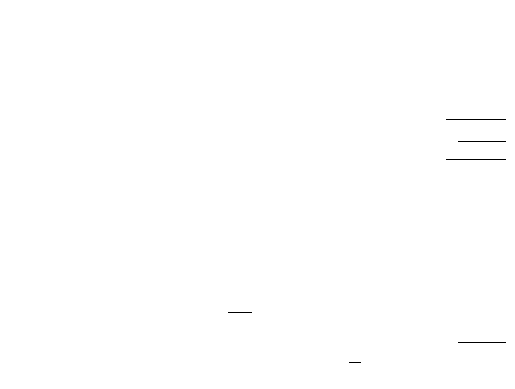

In [4]:
# Plot the heatmap
sns.heatmap(df.isna().astype(int), cmap='binary', xticklabels=False, yticklabels=False, cbar=False)

# Show the plot
plt.show()

In [5]:
# Join the dataframes based on the 'ID' column
if len(df.columns) == len(col_idx):
    if (df.columns == col_idx).all():
        df = pd.merge(
            pd.merge(
                pd.read_csv('data.tsv', delimiter='\t'),
                pd.DataFrame(
                    {
                        'Entry':[headers[idx].split('/')[0].split('_')[0] for idx in df.index],
                        'Index':list(df.index)
                    }
                ),
                on='Entry'
            ),
            df,
            left_on='Index',
            right_index=True,
            how='inner'
        ).copy()
print(df.info)

<bound method DataFrame.info of            Entry        Entry Name   
0     A0A401KD97  A0A401KD97_ASPAW  \
1     A0A024HID4  A0A024HID4_PSEKB   
2     A0A0B7G8U8  A0A0B7G8U8_KLEVA   
3     A0A0D1ZK14  A0A0D1ZK14_9EURO   
4     A0A0F3KB91  A0A0F3KB91_9NEIS   
...          ...               ...   
7221      X8BD72      X8BD72_MYCAV   
7222      X8C3G7      X8C3G7_MYCXE   
7223      X8C7K7      X8C7K7_MYCXE   
7224      X8F6Q2      X8F6Q2_MYCUL   
7225      Y0KGF3      Y0KGF3_9PROT   

                                          Protein names   
0     Bifunctional lycopene cyclase/phytoene synthas...  \
1     Carnitine monooxygenase oxygenase subunit (EC ...   
2     Carnitine monooxygenase oxygenase subunit (EC ...   
3     Choline monooxygenase, chloroplastic (EC 1.14....   
4     Carnitine monooxygenase oxygenase subunit (EC ...   
...                                                 ...   
7221                              Rieske domain protein   
7222                              Riesk

In [6]:
df['Protein names'].value_counts(normalize=True)

Protein names
Aromatic ring-hydroxylating dioxygenase subunit alpha                                                                                0.123997
(2Fe-2S)-binding protein                                                                                                             0.089676
Choline monooxygenase, chloroplastic (EC 1.14.15.7)                                                                                  0.069056
Rieske (2Fe-2S) protein                                                                                                              0.061998
Rieske domain-containing protein                                                                                                     0.059369
                                                                                                                                       ...   
Putative Choline monooxygenase (EC 1.14.15.7)                                                                                        0

In [7]:
# Extract the substrate and enzyme names using regular expressions
matches = df['Protein names'].str.extract(r'(.+?) ([\w\-,]+ase)', flags=re.IGNORECASE)

# String normalization pipeline
df['Substrate'] = matches[0]\
    .fillna('')\
    .apply(lambda x: '/'.join(re.findall(r'\b(\w+(?:ene|ine|ate|yl))\b', x, flags=re.IGNORECASE)))\
    .apply(lambda x: x.lower())

df['Enzyme'] = matches[1]\
    .fillna('')\
    .apply(lambda x: x.split('-')[-1] if '-' in x else x) \
    .apply(lambda x: x.lower())

df = df.copy()

df[['Substrate', 'Enzyme']].value_counts(normalize=True)

Substrate                               Enzyme        
                                                          0.467063
                                        dioxygenase       0.185580
choline                                 monooxygenase     0.090922
phenylpropionate                        dioxygenase       0.072654
benzoate                                dioxygenase       0.043316
anthranilate                            dioxygenase       0.027539
salicylate                              hydroxylase       0.017437
                                        oxygenase         0.015361
biphenyl                                dioxygenase       0.010379
benzene                                 dioxygenase       0.008165
naphthalene                             dioxygenase       0.007750
carnitine                               monooxygenase     0.007750
cumate                                  dioxygenase       0.006643
halobenzoate                            dioxygenase       0.006228
benzoat

In [8]:
df['Enzyme'].value_counts(normalize=True)

Enzyme
                  0.467063
dioxygenase       0.389842
monooxygenase     0.100055
hydroxylase       0.017991
oxygenase         0.015776
demethylase       0.003045
oxidoreductase    0.001384
reductase         0.001384
cyclase           0.000830
synthase          0.000692
diooxygenase      0.000415
decarboxylase     0.000415
dyoxygenase       0.000415
ligase            0.000138
dehydrogenase     0.000138
helicase          0.000138
protease          0.000138
dioxyenase        0.000138
Name: proportion, dtype: float64

In [9]:
df['Substrate'].value_counts(normalize=True)

Substrate
                                          0.672571
choline                                   0.090922
phenylpropionate                          0.072654
benzoate                                  0.043454
anthranilate                              0.027539
salicylate                                0.017714
biphenyl                                  0.010379
benzene                                   0.008165
naphthalene                               0.007750
carnitine                                 0.007750
cumate                                    0.006643
halobenzoate                              0.006228
benzoate/toluate                          0.005397
terephthalate                             0.003737
phenylpropionate/cinnamate                0.003183
glycine/betaine                           0.003045
phthalate                                 0.002629
toluate                                   0.001384
methanesulfonate                          0.001384
phenoxybenzoate      

In [10]:
df['Label'] = df['Substrate'].str.cat(df['Enzyme'], sep=' ').str.strip()
df = df.copy()
df['Label'].value_counts(normalize=True)

Label
                                                        0.467063
dioxygenase                                             0.185580
choline monooxygenase                                   0.090922
phenylpropionate dioxygenase                            0.072654
benzoate dioxygenase                                    0.043316
anthranilate dioxygenase                                0.027539
salicylate hydroxylase                                  0.017437
oxygenase                                               0.015361
biphenyl dioxygenase                                    0.010379
benzene dioxygenase                                     0.008165
carnitine monooxygenase                                 0.007750
naphthalene dioxygenase                                 0.007750
cumate dioxygenase                                      0.006643
halobenzoate dioxygenase                                0.006228
benzoate/toluate dioxygenase                            0.005397
terephthalate dioxy

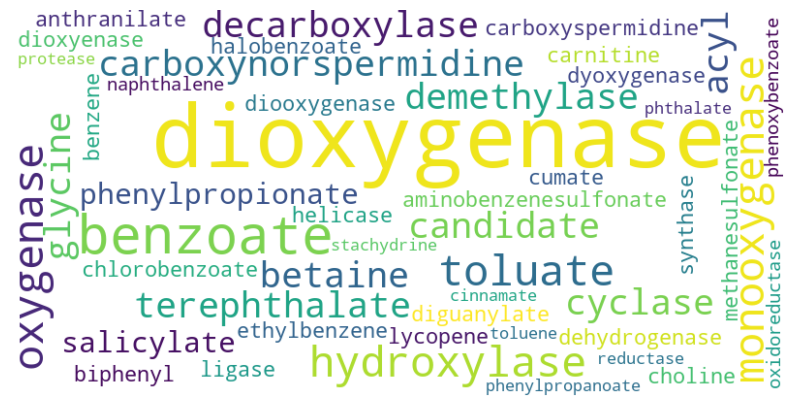

In [11]:
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(
    WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(
        ' '.join(
            sorted(
                set([string for string in df.Label.values.tolist() if len(string) > 0])
            )
        )
    ),
    interpolation='bilinear'
)
plt.axis('off')
plt.show()

In [12]:
data = df[col_idx].drop_duplicates().fillna('-').copy()
data.info

<bound method DataFrame.info of      182 185 186 187 200 204 205 206 216 217  ... 838 841 845 848 851 853 982   
0      K   L   L   I   E   C   Y   H   S   H  ...   V   Y   R   H   R   D   E  \
1      K   S   I   V   E   C   Y   H   A   H  ...   I   Y   F   L   N   K   E   
2      K   N   I   V   E   C   Y   H   A   H  ...   I   Y   F   T   N   E   E   
3      K   T   L   A   E   C   Y   H   A   H  ...   V   Y   R   H   V   D   E   
4      K   I   I   V   E   C   Y   H   A   H  ...   I   Y   F   R   N   K   E   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
7218   K   M   V   V   D   G   Y   H   T   H  ...   A   V   L   I   P   G   D   
7221   K   L   Y   M   E   F   Y   H   L   H  ...   L   Y   F   P   A   P   Q   
7223   K   M   V   V   D   G   Y   H   T   H  ...   A   V   L   M   P   G   D   
7224   K   V   L   V   E   G   Y   H   T   H  ...   S   M   V   T   P   M   -   
7225   K   T   F   I   E   D   Y   H   F   H  ...   F   Y   Y   P   E   D   E

In [13]:
# Perform MCA
mca = MCA()
mca.fit(data)

# Access the results
coordinates = mca.transform(data)

# mca.plot(
#     data,
#     x_component=0,
#     y_component=1
# )

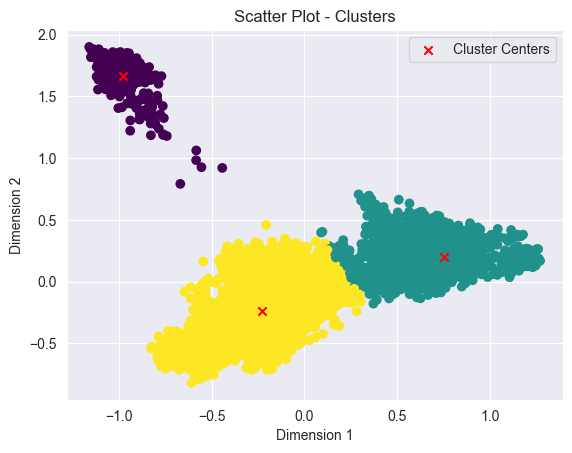

In [14]:
# Assuming 'coordinates' is the result of MCA

# Convert the coordinates to a NumPy array
coordinates = np.array(coordinates)

# Define a range of potential number of clusters to evaluate
min_clusters = 3
max_clusters = 10

# Perform clustering for different number of clusters and compute silhouette scores
silhouette_scores = []
for k in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, n_init=10)  # Set n_init explicitly
    kmeans.fit(coordinates)
    labels = kmeans.labels_
    score = silhouette_score(coordinates, labels)
    silhouette_scores.append(score)

# Find the best number of clusters based on the highest silhouette score
best_num_clusters = np.argmax(silhouette_scores) + min_clusters

# Perform clustering with the best number of clusters
kmeans = KMeans(n_clusters=best_num_clusters, n_init=10)  # Set n_init explicitly
kmeans.fit(coordinates)
kmeans_cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Plot the scatter plot colored by clusters
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans_cluster_labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', label='Cluster Centers')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot - Clusters')
plt.legend()
plt.show()

In [15]:
X = data
y = pd.get_dummies(kmeans_cluster_labels).astype(int) if len(
    set(kmeans_cluster_labels)
) > 2 else kmeans_cluster_labels

# Perform one-hot encoding on the categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

# Get the column names for the encoded features
encoded_feature_names = []
for i, column in enumerate(X.columns):
    categories = encoder.categories_[i]
    for category in categories:
        feature_name = f'{column}_{category}'
        encoded_feature_names.append(feature_name)

# Convert X_encoded to DataFrame
X_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_encoded, columns=encoded_feature_names)

# Create and train the Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_encoded_df, y)

# Feature selection
feature_selector = SelectFromModel(rf, threshold='median')
X_selected = feature_selector.fit_transform(X_encoded_df, y)

selected_feature_indices = feature_selector.get_support(indices=True)
selected_features = X_encoded_df.columns[selected_feature_indices]

selected_features

Index(['182_K', '185_A', '185_F', '185_I', '185_L', '185_M', '185_N', '185_S',
       '185_T', '185_V',
       ...
       '987_D', '987_E', '987_F', '987_H', '987_P', '987_Q', '987_R', '987_S',
       '987_V', '987_W'],
      dtype='object', length=364)

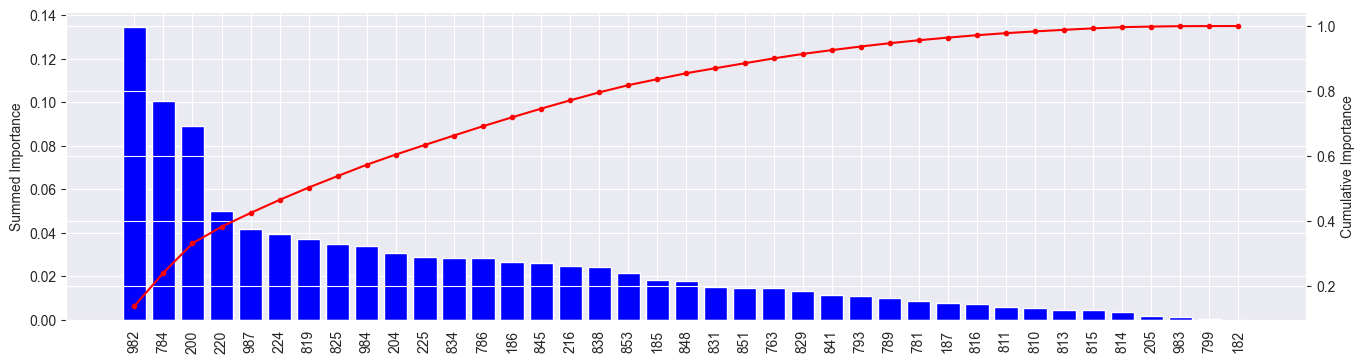

In [16]:
# Calculate feature importances for original columns
sorted_importance = pd.DataFrame(
    {
        'Residues': selected_features,
        'Importance': rf.feature_importances_[selected_feature_indices],
        'Columns': map(lambda x: int(x.split('_')[0]), selected_features)
    }
)[['Columns', 'Importance']].groupby('Columns').sum()['Importance'].sort_values(ascending=False)
sorted_features = sorted_importance.index

fig, ax1 = plt.subplots(figsize=(16, 4))

# Bar chart of percentage importance
xvalues = range(len(sorted_features))
ax1.bar(xvalues, sorted_importance, color='b')
ax1.set_ylabel('Summed Importance')
ax1.tick_params(axis='y')

# Line chart of cumulative percentage importance
ax2 = ax1.twinx()
ax2.plot(xvalues, np.cumsum(sorted_importance) / np.sum(sorted_importance), color='r', marker='.')
ax2.set_ylabel('Cumulative Importance')
ax2.tick_params(axis='y')

# Rotate x-axis labels
plt.xticks(xvalues, sorted_features)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

plt.show()


In [17]:
# Calculate cumulative sum of importance
cumulative_importance = np.cumsum(sorted_importance) / np.sum(sorted_importance)

# Find the index where cumulative importance exceeds or equals 0.9
index = np.where(cumulative_importance >= 0.9)[0][0]

# Get the values from sorted_features up to the index
selected_columns = sorted_features[:index+1].values

# Print the retrieved values
print(selected_columns)

[982 784 200 220 987 224 819 825 984 204 225 834 786 186 845 216 838 853
 185 848 831 851 763]


In [18]:
def henikoff(data):
    data_array = data.to_numpy()  # Convert DataFrame to NumPy array
    size, length = data_array.shape
    weights = []
    for seq_index in range(size):
        row = data_array[seq_index, :]
        unique_vals, counts = np.unique(row, return_counts=True)
        k = len(unique_vals)
        matrix_row = 1. / (k * counts)
        weights.append(np.sum(matrix_row) / length)
    return pd.Series(weights, index=data.index)

In [19]:
weights = henikoff(data[selected_columns])
print(weights)

0       0.031494
1       0.033816
2       0.034873
3       0.031573
4       0.034058
          ...   
7218    0.030100
7221    0.028684
7223    0.031215
7224    0.035300
7225    0.031884
Length: 6219, dtype: float64


In [20]:
data[selected_columns]

,982,784,200,220,987,224,819,825,984,204,...,186,845,216,838,853,185,848,831,851,763
0,E,Q,E,P,D,L,K,I,R,C,...,L,R,S,V,D,L,H,N,R,C
1,E,I,E,P,R,S,L,Q,L,C,...,I,F,A,I,K,S,L,Y,N,T
2,E,T,E,P,R,G,L,Q,L,C,...,I,F,A,I,E,N,T,Y,N,M
3,E,M,E,P,H,D,S,M,K,C,...,L,R,A,V,D,T,H,Y,V,Y
4,E,I,E,P,R,G,L,Q,L,C,...,I,F,A,I,K,I,R,Y,N,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7218,D,M,D,A,E,S,I,A,G,G,...,V,L,T,A,G,M,I,T,P,N
7221,Q,Y,E,A,N,N,V,F,A,F,...,Y,F,L,L,P,L,P,G,A,L
7223,D,M,D,A,E,S,I,A,G,G,...,V,L,T,A,G,M,M,T,P,N
7224,-,V,E,K,-,D,A,V,-,G,...,L,V,T,S,M,V,T,I,P,A


In [21]:
selected_residues = [x for x in selected_features if int(x.split('_')[0]) in selected_columns]
df_res = mca.column_coordinates(data[selected_columns]).loc[selected_residues]
df_res.info

<bound method DataFrame.info of               0         1
185_A -0.055679 -0.235596
185_F  0.994968  0.235741
185_I  0.365914 -0.061224
185_L -0.005871 -0.292775
185_M  1.200784  0.144714
...         ...       ...
987_Q -0.337591 -0.532113
987_R -0.543242 -0.609010
987_S -0.249538 -0.656427
987_V  0.226807 -0.123704
987_W -0.085255 -0.159382

[250 rows x 2 columns]>

In [22]:
# Create an empty graph
G = nx.Graph()
for idx in df_res.index:
    col, aa = idx.split('_')
    col = int(col)
    rows = data[selected_columns].index[data[selected_columns][col] == aa].tolist()
    # Filter and sum values based on valid indices
    p = weights.iloc[[i for i in rows if i < len(weights)]].sum()
    # Add a node with attributes
    G.add_node(
        f'{seq3(aa)}{col}',
        idx=idx,
        aa=aa,
        col=col,
        coord=(
            df_res.loc[idx,0],
            df_res.loc[idx,1]
        ),
        rows=rows,
        p=p
    )
G.nodes

NodeView(('Ala185', 'Phe185', 'Ile185', 'Leu185', 'Met185', 'Asn185', 'Ser185', 'Thr185', 'Val185', 'Ala186', 'Phe186', 'Gly186', 'His186', 'Ile186', 'Leu186', 'Met186', 'Pro186', 'Gln186', 'Val186', 'Tyr186', 'Ala200', 'Asp200', 'Glu200', 'Gly200', 'Ser200', 'Ala204', 'Cys204', 'Asp204', 'Phe204', 'Gly204', 'His204', 'Met204', 'Asn204', 'Pro204', 'Ser204', 'Thr204', 'Val204', 'Ala216', 'Phe216', 'Ile216', 'Leu216', 'Asn216', 'Ser216', 'Thr216', 'Val216', 'Ala220', 'Asp220', 'Glu220', 'Gly220', 'Lys220', 'Leu220', 'Pro220', 'Gln220', 'Arg220', 'Ser220', 'Thr220', 'Trp220', 'Tyr220', 'Ala224', 'Asp224', 'Glu224', 'Phe224', 'Gly224', 'Lys224', 'Asn224', 'Gln224', 'Ser224', 'Thr224', 'Trp224', 'Ala225', 'Phe225', 'Ile225', 'Leu225', 'Pro225', 'Ser225', 'Thr225', 'Val225', 'Tyr225', 'Ala763', 'Asp763', 'Phe763', 'Gly763', 'Ile763', 'Leu763', 'Asn763', 'Gln763', 'Arg763', 'Ser763', 'Thr763', 'Val763', 'Ala784', 'Glu784', 'Phe784', 'His784', 'Ile784', 'Lys784', 'Leu784', 'Met784', 'Asn784', 

In [23]:
nodelist = sorted(G.nodes(), key=lambda x: G.nodes[x]['p'], reverse=True)
df_res = df_res.loc[[G.nodes[u]['idx'] for u in nodelist]]
df_res.columns = ['x_mca', 'y_mca']
df_res = df_res.copy()
df_res

,x_mca,y_mca
200_E,-0.579361,-0.171188
220_P,-0.689378,-0.135222
982_E,-0.360173,0.324835
185_L,-0.005871,-0.292775
225_L,-0.716184,0.032434
...,...,...
784_K,1.275230,0.427134
186_H,0.751276,0.125129
204_H,0.397603,0.045041
784_E,0.418789,-0.084325


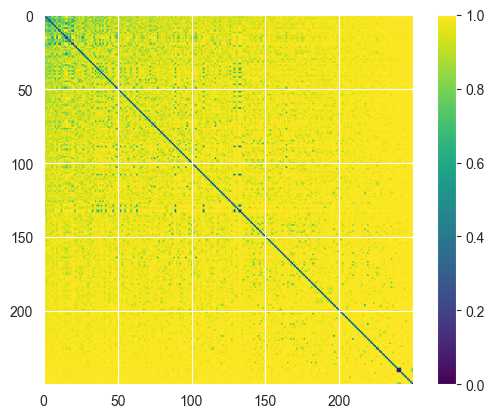

In [24]:
# Generate pairwise combinations
pairwise_comparisons = list(combinations(G.nodes, 2))

# Add edges to graph based on pairwise calculation of Jaccard's dissimilarity (1 - similarity)
for u, v in pairwise_comparisons:
    asymmetric_distance = set(G.nodes[u]['rows']) ^ set(G.nodes[v]['rows'])
    union = set(G.nodes[u]['rows']) | set(G.nodes[v]['rows'])
    weight = float(
        weights.iloc[[i for i in list(asymmetric_distance) if i < len(weights)]].sum()
    ) / float(
        weights.iloc[[i for i in list(union) if i < len(weights)]].sum()
    ) if G.nodes[u]['col'] != G.nodes[v]['col'] else 1.
    G.add_edge(
        u,
        v,
        weight = weight
    )

# Generate distance matrix
D = nx.to_numpy_array(G, nodelist=nodelist)

# Plot the distance matrix
fig, ax = plt.subplots()
im = ax.imshow(D, cmap='viridis')

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

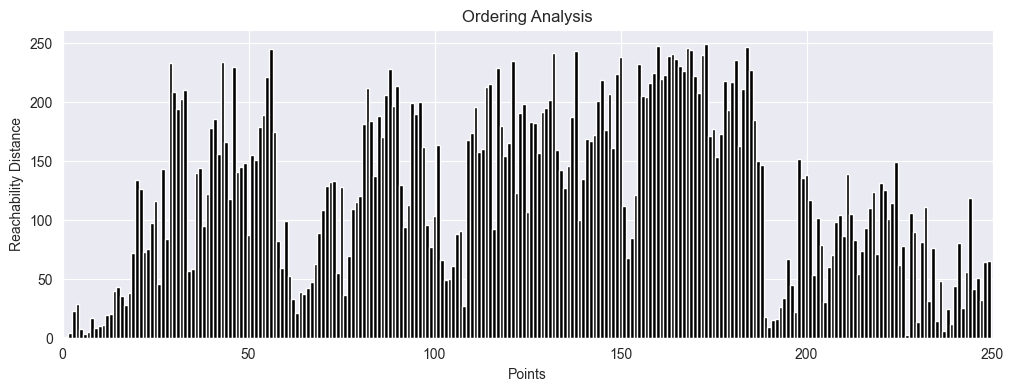

In [25]:
# Assuming D is the distance matrix

# Perform MDS to obtain the actual points
mds = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto')
points = mds.fit_transform(D)

# Apply OPTICS on the points
optics = OPTICS()
optics.fit(points)

ordering = optics.ordering_
# Retrieve cluster labels and ordering information
cluster_labels = optics.labels_

# Plot the ordering analysis
plt.figure(figsize=(12, 4))
plt.bar(range(len(ordering)), ordering, width=1., color='black')
plt.xlim([0, len(ordering)])
plt.xlabel('Points')
plt.ylabel('Reachability Distance')
plt.title('Ordering Analysis')
plt.show()

In [26]:
df_res['x_mds'] = points[:,0]
df_res['y_mds'] = points[:,1]
df_res['label'] = cluster_labels
df_res = df_res.copy()
df_res

,x_mca,y_mca,x_mds,y_mds,label
200_E,-0.579361,-0.171188,-0.187763,0.305940,-1
220_P,-0.689378,-0.135222,-0.200850,0.367679,-1
982_E,-0.360173,0.324835,-0.194065,0.177820,-1
185_L,-0.005871,-0.292775,0.068022,0.317736,-1
225_L,-0.716184,0.032434,-0.237056,0.360122,-1
...,...,...,...,...,...
784_K,1.275230,0.427134,-0.783368,0.207137,-1
186_H,0.751276,0.125129,-0.320783,-0.723895,-1
204_H,0.397603,0.045041,-0.625786,-0.505517,-1
784_E,0.418789,-0.084325,0.028323,-0.802106,11


In [27]:
# Find the unique values and their counts
unique_values, counts = np.unique(cluster_labels, return_counts=True)

# Calculate the proportion of unique values
proportions = counts / len(cluster_labels)

# Print the unique values and their proportions
for value, count, proportion in zip(unique_values, counts, proportions):
    print(value, count, proportion)

-1 127 0.508
0 6 0.024
1 6 0.024
2 8 0.032
3 8 0.032
4 16 0.064
5 9 0.036
6 13 0.052
7 6 0.024
8 6 0.024
9 7 0.028
10 6 0.024
11 6 0.024
12 7 0.028
13 7 0.028
14 12 0.048


/var/folders/3s/lcw00jp9337f6sn4ym0dg10w0000gp/T/ipykernel_62931/2757430404.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab10', len(unique_labels))


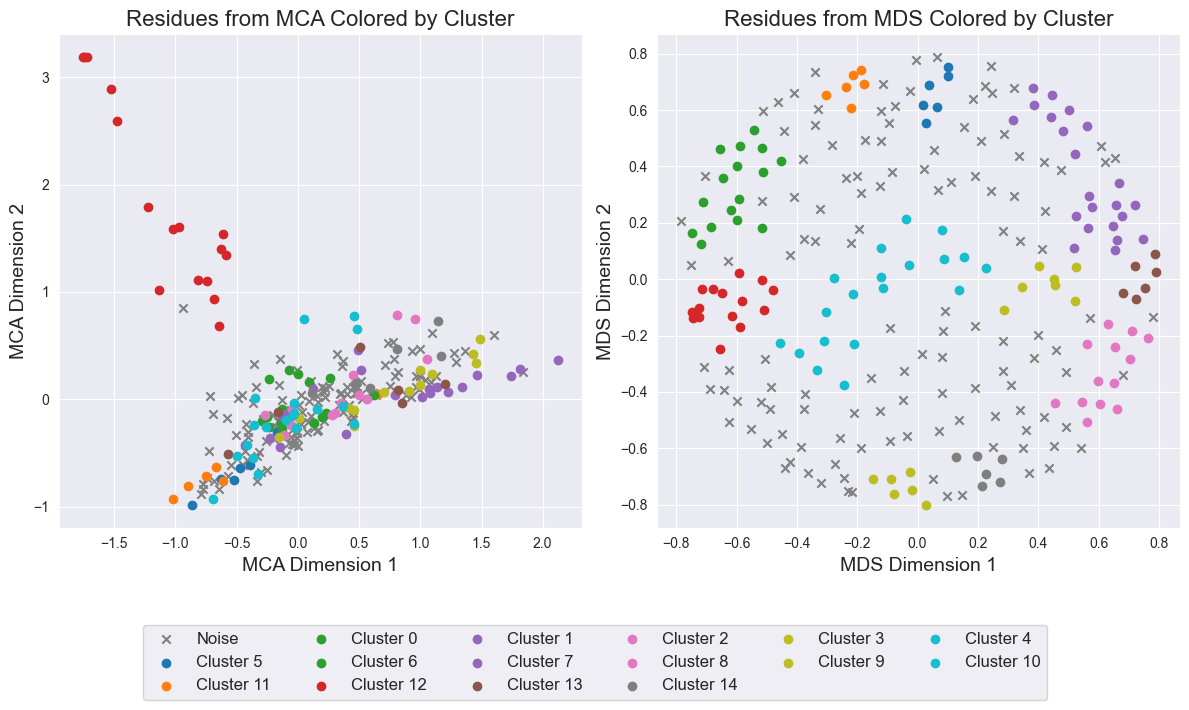

In [28]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 7))

# Plot for MCA
axs[0].set_xlabel('MCA Dimension 1', fontsize=14)
axs[0].set_ylabel('MCA Dimension 2', fontsize=14)
axs[0].set_title('Residues from MCA Colored by Cluster', fontsize=16)

# Plot for MDS
axs[1].set_xlabel('MDS Dimension 1', fontsize=14)
axs[1].set_ylabel('MDS Dimension 2', fontsize=14)
axs[1].set_title('Residues from MDS Colored by Cluster', fontsize=16)

x_mca = df_res['x_mca']
y_mca = df_res['y_mca']

x_mds = df_res['x_mds']
y_mds = df_res['y_mds']

labels = df_res['label']
unique_labels = np.unique(labels)
color_map = cm.get_cmap('tab10', len(unique_labels))

handles = []
all_labels = []

for i, cluster_label in enumerate(unique_labels):
    if cluster_label == -1:
        noise_color = 'grey'
        noise_marker = 'x'
        label = 'Noise'
    else:
        noise_color = color_map(i)
        noise_marker = 'o'
        label = f'Cluster {cluster_label}'

    scatter_mca = axs[0].scatter(x_mca[labels == cluster_label], y_mca[labels == cluster_label], color=noise_color, marker=noise_marker, label=label)
    scatter_mds = axs[1].scatter(x_mds[labels == cluster_label], y_mds[labels == cluster_label], color=noise_color, marker=noise_marker, label=label)

    # Collect the scatter plot handles and labels
    handles.append(scatter_mca)
    all_labels.append(label)

# Rearrange labels to fill one row first and then the second row
n_cols = 6  # Number of columns in the legend
all_labels_reordered = [all_labels[i::n_cols] for i in range(n_cols)]
all_labels_reordered = sum(all_labels_reordered, [])  # Flatten the nested list

# Create a single legend for both subplots with reordered labels
fig.legend(handles, all_labels_reordered, bbox_to_anchor=(0.5, 0.0), loc='upper center', borderaxespad=0, ncol=n_cols, fontsize=12)

# ...

# Adjust the layout to accommodate the legend
fig.tight_layout(rect=[0, 0.05, 1, 0.9])

# Show the plot
plt.show()